In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral208.jpeg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral29.jpeg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral236.jpeg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral81.jpg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral106.jpeg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral107.jpg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral123.jpg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral46.png
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral121.jpg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral290.jpeg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral273.jpg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral20.jpeg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral105.jpg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral113.jpg
/kaggle/input/vsa-data2/Med/TrainMed/Train/neutral/neutral6.jpg
/kaggle/in

In [3]:

import warnings
warnings.filterwarnings("ignore")

#!pip install pyyaml

In [4]:
from keras.layers import Concatenate, Conv2D, Dropout, AveragePooling2D, ZeroPadding2D
from keras.layers import BatchNormalization, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Input

def densenet121_model(img_rows, img_cols, color_type=1, nb_dense_block=4, growth_rate=32,
                      nb_filter=64, reduction=0.5, dropout_rate=0.0, weight_decay=1e-4, num_classes=None):
    '''
    DenseNet 121 Model for Keras - Minimal Fix Version
    '''

    # Handle Dimension Ordering
    global concat_axis
    concat_axis = -1  # Channel last (default in TF backend)
    img_input = Input(shape=(img_rows, img_cols, color_type), name='data')

    # DenseNet-121 architecture configuration
    nb_layers = [6, 12, 24, 16]  # For DenseNet-121

    # Initial convolution
    x = Conv2D(nb_filter, (7, 7), strides=(2, 2), padding='same', use_bias=False, name='conv1')(img_input)
    x = BatchNormalization(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        stage = block_idx + 2
        x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate)
        x = transition_block(x, stage, nb_filter, dropout_rate=dropout_rate)
        nb_filter = int(nb_filter)

    # Final dense block
    final_stage = stage + 1
    x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate)

    # Final batch norm + activation
    x = BatchNormalization(axis=concat_axis)(x)
    x = Activation('relu')(x)

    # Classification block
    x_fc = GlobalAveragePooling2D()(x)
    x_fc = Dense(num_classes)(x_fc)
    x_fc = Activation('softmax')(x_fc)

    model = Model(inputs=img_input, outputs=x_fc)

    # Compile model
    sgd = SGD(learning_rate=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [5]:
from keras.layers import Conv2D, Dropout, ZeroPadding2D, BatchNormalization, Activation, AveragePooling2D, Concatenate

def conv_block(x, stage, branch, nb_filter, dropout_rate=None):
    '''Apply BatchNorm, ReLU, bottleneck 1x1 Conv2D, 3x3 Conv2D, optional Dropout'''

    inter_channel = nb_filter * 4  

    x = BatchNormalization(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = Conv2D(inter_channel, (1, 1), use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = BatchNormalization(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(nb_filter, (3, 3), use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x


def transition_block(x, stage, nb_filter, dropout_rate=None):
    '''Apply BatchNorm, 1x1 Conv2D, AveragePooling, optional Dropout'''

    x = BatchNormalization(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = Conv2D(int(nb_filter), (1, 1), use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2))(x)

    return x


def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, grow_nb_filters=True):
    '''Build a dense_block where output of each conv_block is concatenated'''

    concat_feat = x

    for i in range(nb_layers):
        branch = i + 1
        x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate)
        concat_feat = Concatenate(axis=concat_axis)([concat_feat, x])

        if grow_nb_filters:
            nb_filter += growth_rate

    return concat_feat, nb_filter


In [7]:
from keras.layers import Layer
from keras import backend as K

class Scale(Layer):
    """Custom Scale layer that applies a per-channel scaling (gamma) and shift (beta).
    Historically used with DenseNet models.
    """

    def __init__(self, axis=-1, **kwargs):
        super(Scale, self).__init__(**kwargs)
        self.axis = axis

    def build(self, input_shape):
        channel_dim = input_shape[self.axis]
        self.gamma = self.add_weight(
            name='gamma',
            shape=(channel_dim,),
            initializer='ones',
            trainable=True
        )
        self.beta = self.add_weight(
            name='beta',
            shape=(channel_dim,),
            initializer='zeros',
            trainable=True
        )
        super().build(input_shape)

    def call(self, inputs):
        return self.gamma * inputs + self.beta

    def compute_output_shape(self, input_shape):
        return input_shape


In [8]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import img_to_array

def load_data():
    train_path = "/kaggle/input/vsa-data2/Med/TrainMed/Train"
    test_path = "/kaggle/input/vsa-data2/Med/TestMed/Test"

    def load_images_from_directory(base_path):
        data = []
        labels = []
        for class_name in sorted(os.listdir(base_path)):
            class_dir = os.path.join(base_path, class_name)
            if not os.path.isdir(class_dir):
                continue
            for image_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, image_file)
                image = cv2.imread(img_path)
                if image is None:
                    continue
                image = cv2.resize(image, (224, 224))
                image = img_to_array(image)
                data.append(image)
                labels.append(class_name.lower())
        return np.array(data, dtype="float32") / 255.0, labels

    print("[INFO] Loading training data...")
    x_train, y_train = load_images_from_directory(train_path)

    print("[INFO] Loading testing data...")
    x_test, y_test = load_images_from_directory(test_path)

    lb = LabelBinarizer()
    y_train = lb.fit_transform(y_train)
    y_test = lb.transform(y_test)

    return x_train, y_train, x_test, y_test


In [9]:
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import log_loss

if __name__ == '__main__':
    # Input dimensions and dataset classes
    img_rows, img_cols = 224, 224
    channel = 3
    num_classes = 3  # Positive, Negative, Neutral
    batch_size = 16 
    epochs = 10

    # Load preprocessed image dataset
    X_train, Y_train, X_valid, Y_valid = load_data()

    # Initialize the DenseNet121 model
    model = densenet121_model(
        img_rows=img_rows, 
        img_cols=img_cols, 
        color_type=channel, 
        num_classes=num_classes
    )

    # Compile model
    model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
    )

    # Define a checkpoint to save the best model based on validation accuracy
    checkpoint = ModelCheckpoint(
        filepath="bestmodel.keras", 
        monitor='val_accuracy', 
        verbose=1, 
        save_best_only=True, 
        mode='max'
    )
    callbacks_list = [checkpoint]

    # Train the model
    history = model.fit(
        X_train, Y_train,
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        verbose=1,
        validation_data=(X_valid, Y_valid),
        callbacks=callbacks_list
    )

    # Evaluate on validation data
    predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=1)
    score = log_loss(Y_valid, predictions_valid)
    print("Validation Log Loss:", score)


[INFO] Loading training data...


libpng warning: iCCP: known incorrect sRGB profile


[INFO] Loading testing data...


I0000 00:00:1753560122.824326      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/10


I0000 00:00:1753560216.356440      97 service.cc:148] XLA service 0x7f9304003aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753560216.357343      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753560225.033477      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/57 ━━━━━━━━━━━━━━━━━━━━ 2:46:00 178s/step - accuracy: 0.4375 - loss: 1.1647

I0000 00:00:1753560304.790323      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4405 - loss: 1.5472   
Epoch 1: val_accuracy improved from -inf to 0.17000, saving model to bestmodel.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.4414 - loss: 1.5421 - val_accuracy: 0.1700 - val_loss: 3.3257
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5076 - loss: 1.0126
Epoch 2: val_accuracy improved from 0.17000 to 0.23000, saving model to bestmodel.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.5082 - loss: 1.0119 - val_accuracy: 0.2300 - val_loss: 1.4022
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5972 - loss: 0.8848
Epoch 3: val_accuracy improved from 0.23000 to 0.40000, saving model to bestmodel.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.5967 - loss: 0.8854 - val_accuracy: 0.4000 - val_loss: 6.7371
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5959 - loss: 0.9440
Epoch 4: val_accuracy improved from 0.40000 to 0.45000, 

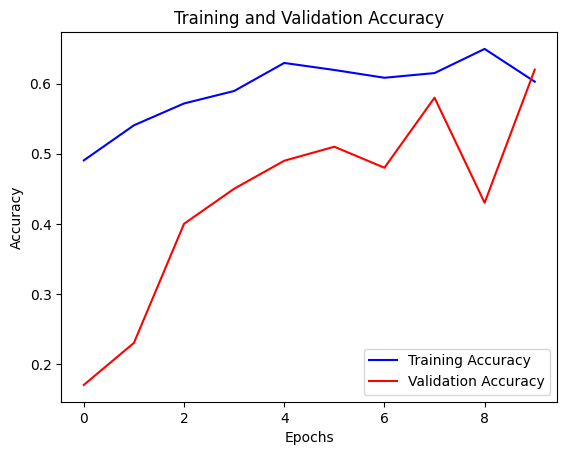

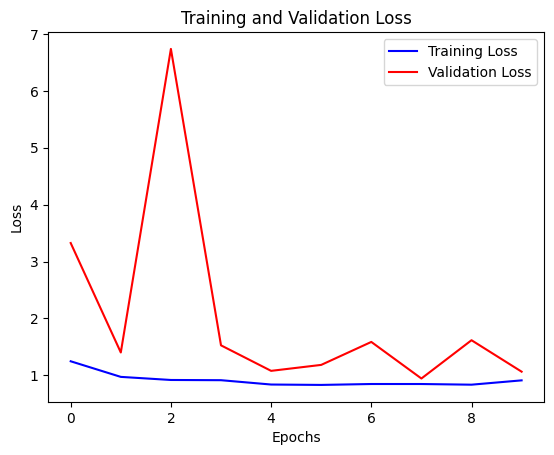

In [10]:
# Evaluating Accuracy and Loss of the model
%matplotlib inline
import matplotlib.pyplot as plt

# Use correct keys based on modern Keras versions
acc = history.history.get('accuracy') or history.history.get('acc')
val_acc = history.history.get('val_accuracy') or history.history.get('val_acc')
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))  # Number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
import numpy as np

# Predict on validation/test data
ypred = model.predict(X_valid)

# Initialize counters
total = len(ypred)
accurate = 0
accurateindex = []
wrongindex = []

# Compare predicted vs actual labels
for i in range(total):
    pred_label = np.argmax(ypred[i])
    true_label = np.argmax(Y_valid[i])
    
    if pred_label == true_label:
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)

# Display results
print(f"Total test samples: {total}")
print(f"Correct predictions: {accurate}")
print(f"Wrong predictions: {total - accurate}")
print(f"Accuracy: {round((accurate / total) * 100, 3)} %")


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step
Total test samples: 100
Correct predictions: 62
Wrong predictions: 38
Accuracy: 62.0 %


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

ytrue_labels = np.argmax(Y_valid, axis=1)
ypred_labels = np.argmax(ypred, axis=1)

# Print classification report
print(classification_report(ytrue_labels, ypred_labels))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(ytrue_labels, ypred_labels))


              precision    recall  f1-score   support

           0       0.88      0.23      0.37        30
           1       0.48      0.90      0.63        30
           2       0.78      0.70      0.74        40

    accuracy                           0.62       100
   macro avg       0.71      0.61      0.58       100
weighted avg       0.72      0.62      0.59       100

Confusion Matrix:
[[ 7 17  6]
 [ 1 27  2]
 [ 0 12 28]]


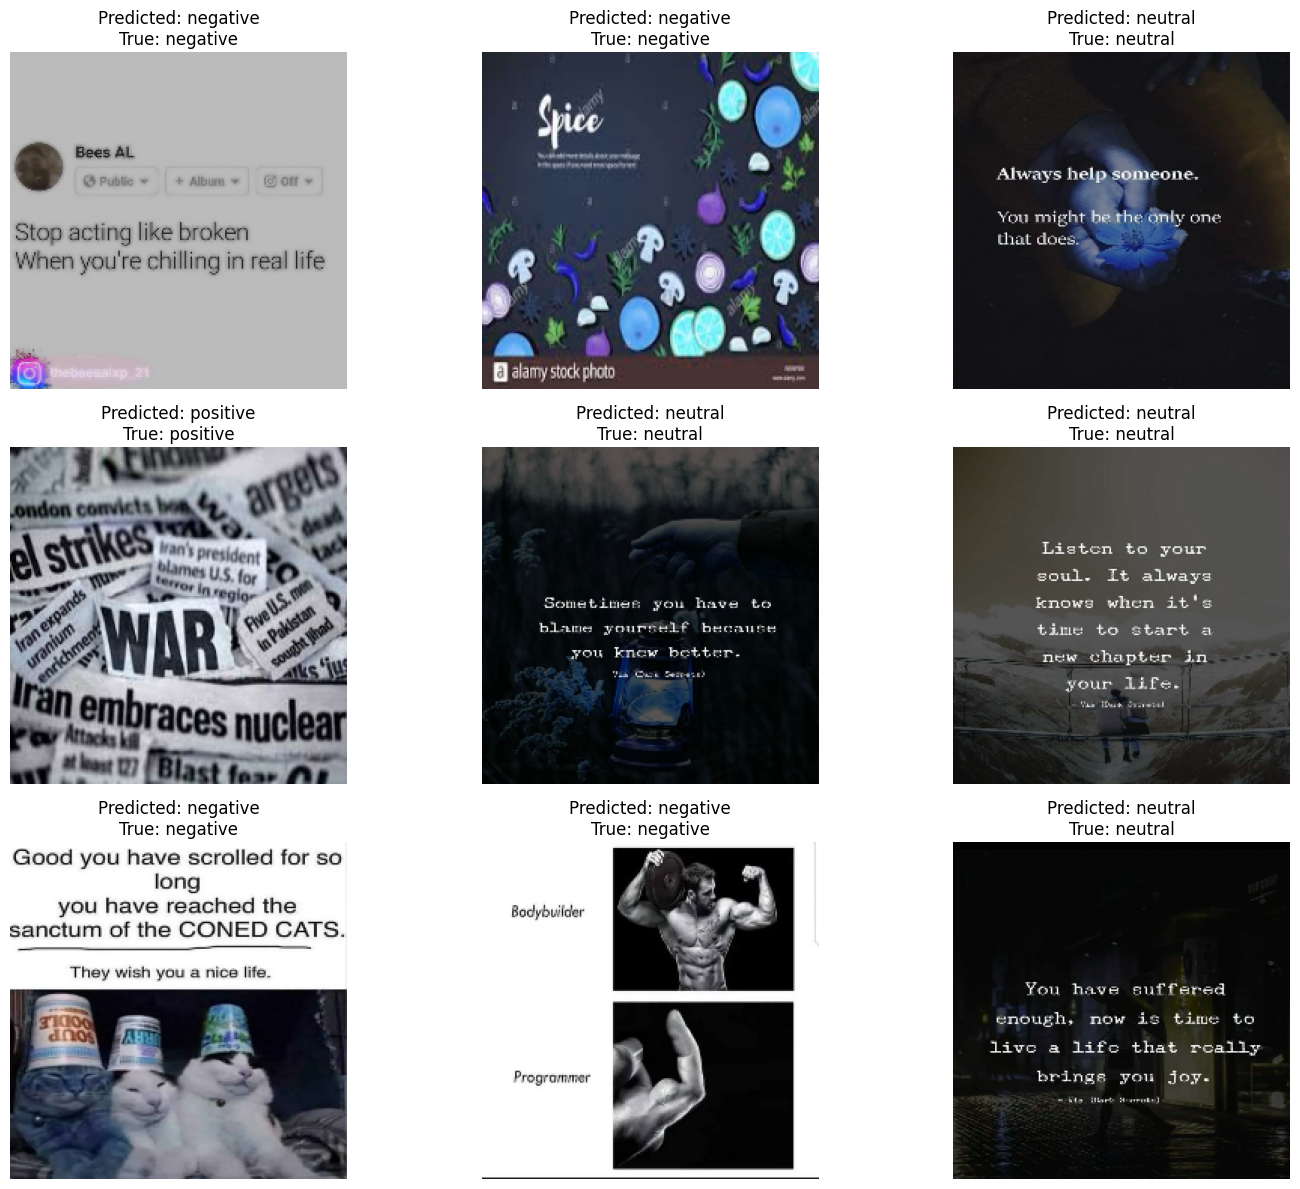

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Labels as per your classification task
labels = ['positive', 'negative', 'neutral']

# Get predicted and true labels
ytrue_labels = np.argmax(Y_valid, axis=1)
ypred_labels = np.argmax(predictions_valid, axis=1)

# Find indices where prediction is correct (or use "wrongindex" for errors)
accurateindex = np.where(ytrue_labels == ypred_labels)[0]
# For incorrect predictions use: wrongindex = np.where(ytrue_labels != ypred_labels)[0]

# Randomly sample 9 correct predictions
imidx = random.sample(list(accurateindex), k=9)

# Plot
nrows, ncols = 3, 3
fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
        ax[row, col].imshow(X_valid[imidx[n]])
        pred_label = labels[ypred_labels[imidx[n]]]
        true_label = labels[ytrue_labels[imidx[n]]]
        ax[row, col].set_title(f"Predicted: {pred_label}\nTrue: {true_label}", fontsize=12)
        ax[row, col].axis('off')
        n += 1

plt.tight_layout()
plt.show()
